In [1]:
import os
import pysr
import sympy
import numpy as np
from matplotlib import pyplot as plt
from pysr import PySRRegressor
from lib.data import prepare_nuclear_data
from lib.utils import  get_rms
from lib.utils import Physics, IO

from lib.data import semi_empirical_mass_formula, semi_empirical_mass_formula_new

from sklearn.linear_model import LinearRegression
import pickle
from sympy import latex, symbols

from argparse import Namespace

import pandas as pd

import seaborn as sns
import torch
sns.set_style('darkgrid')
sns.set_context('paper')

In [2]:
feats = np.load('features/all-pca_features.npy')
phy_terms = np.load('features/physics_terms.npy')
#zn = np.load('features/zn.npy')
zn = np.stack([feats[0], feats[1]], axis=1)

feats = feats[2:]

BE = np.load('./features/BE.npy')

In [3]:
# load args from disk
task = "binding_semf"
args = IO.load_args(f"args.yaml")

data = prepare_nuclear_data(args)
X = data.X 
y = data.y.view(-1)
mask = (X[:, 2] == 0) & ~torch.isnan(y)
X, y = X[mask], y[mask]

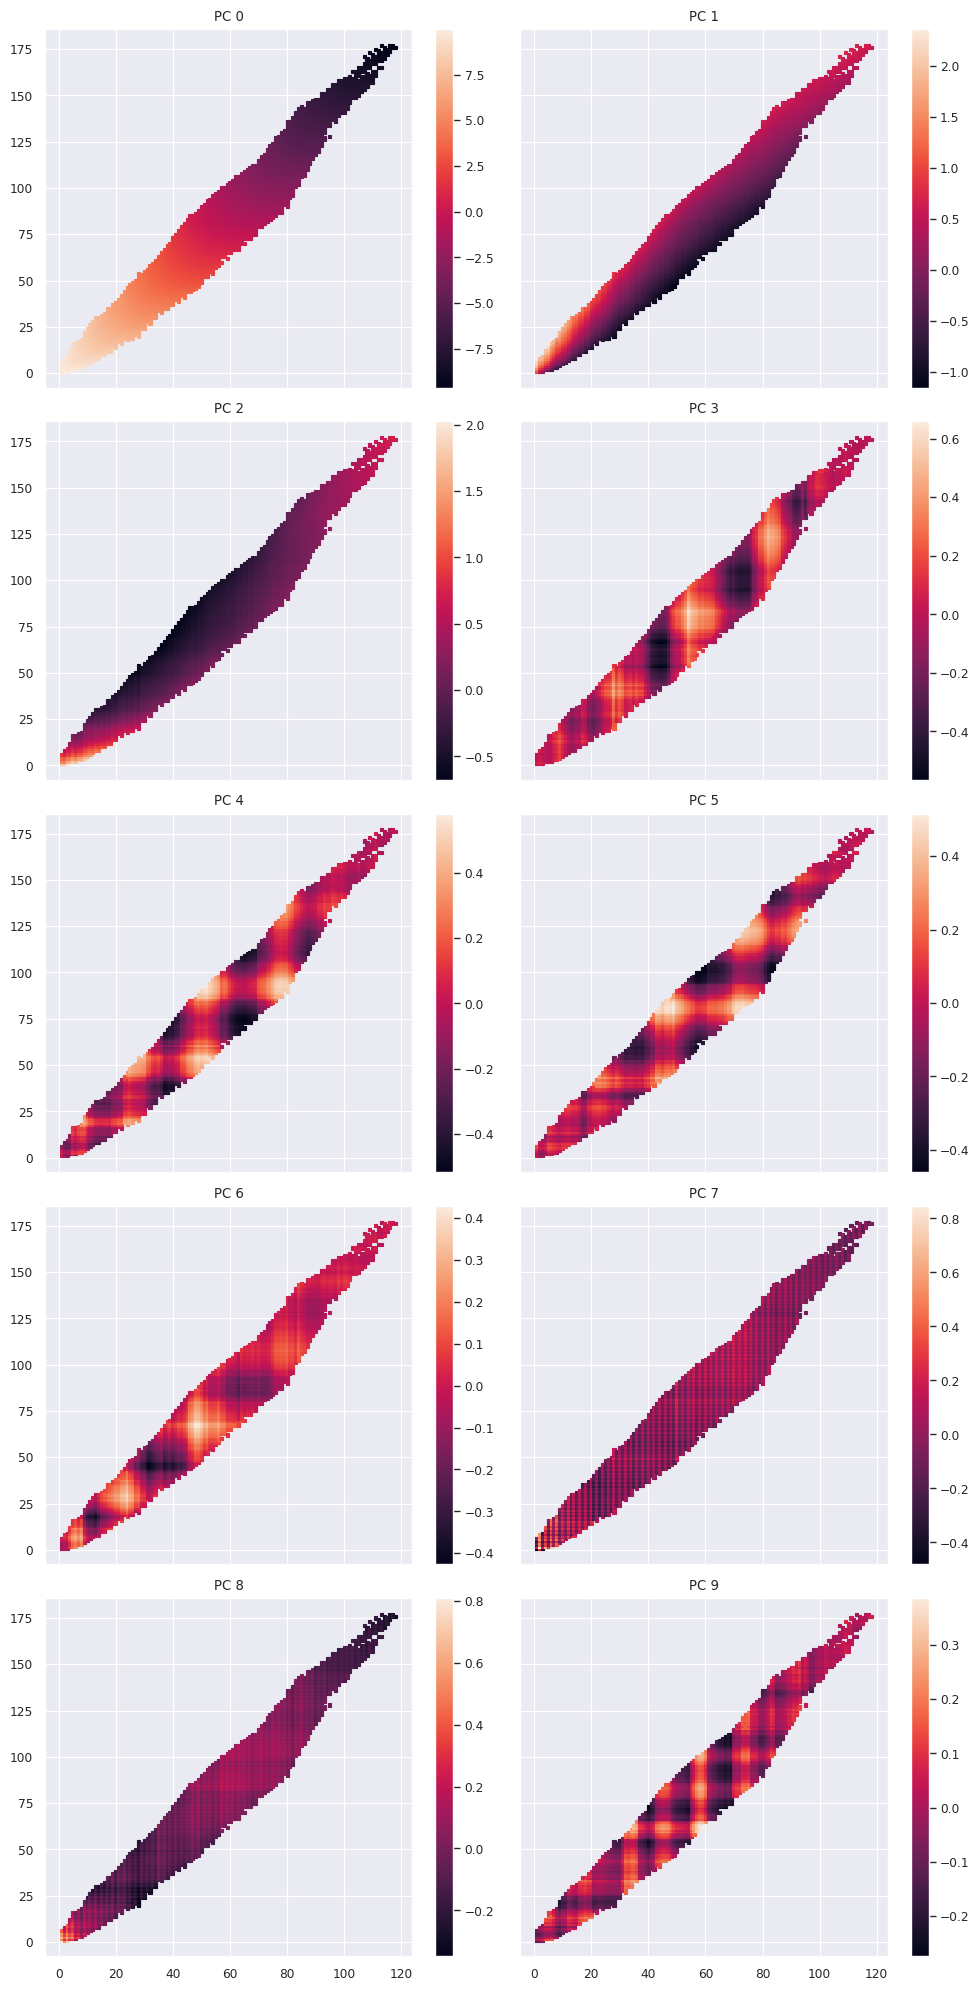

In [4]:
# Plot all PCs
num_plots = min(feats.shape[0], 10)
fig, axes = plt.subplots(max(num_plots//2, 1), 2, figsize=(10, 2 * num_plots), sharex=True, sharey=True)
axes = axes.flatten()
Z, N = zn[:, 0], zn[:, 1]

features = feats
for i in range(10):
    ax = axes.flatten()[i]
    sc = ax.scatter(Z, N, c=features[i], s=5, marker='s')
    ax.set_title(f"PC {i}")
    fig.colorbar(sc, ax=ax)
fig.tight_layout()

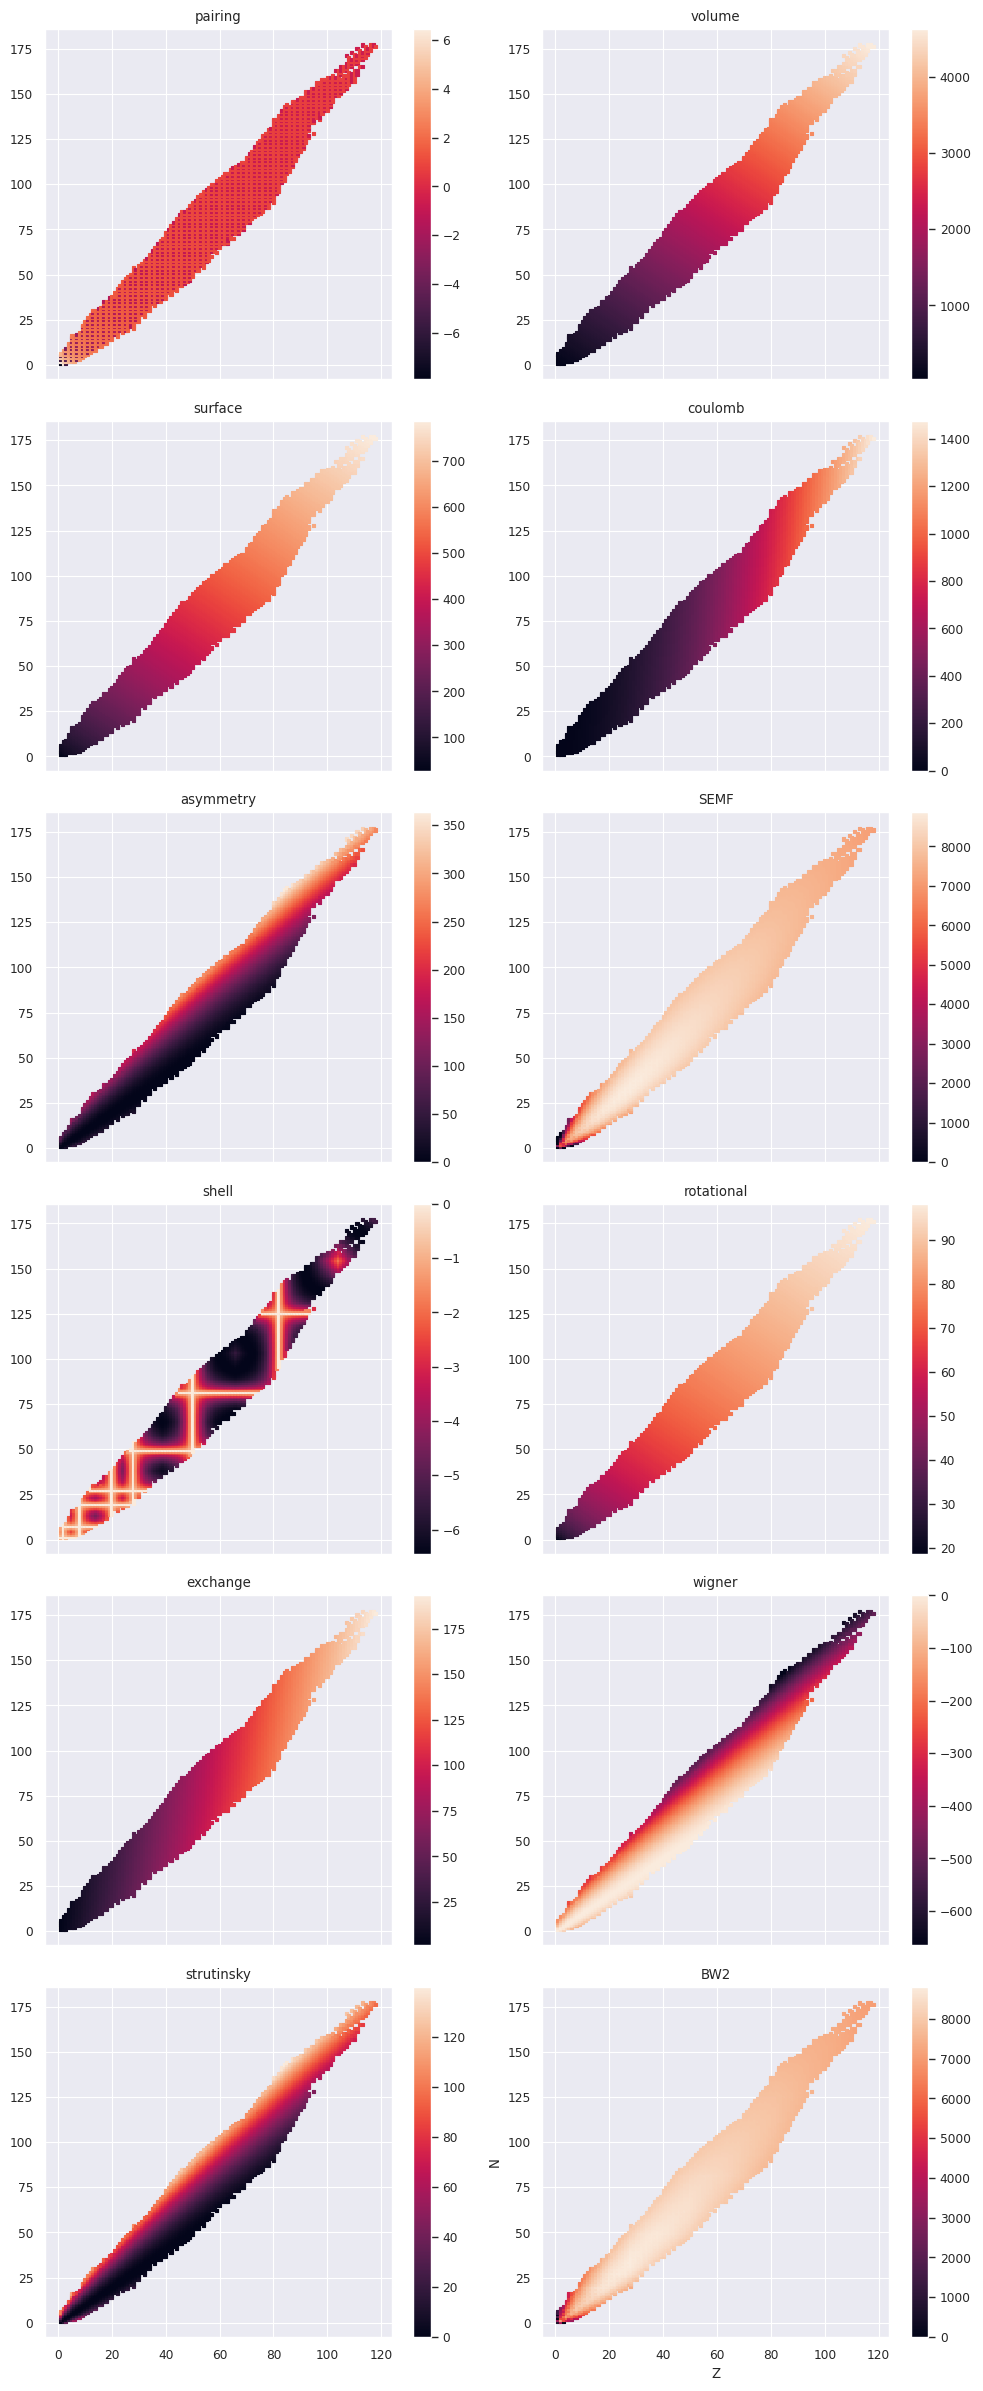

In [5]:
# Plot all terms
terms = [getattr(Physics, func) for func in Physics.all_funcs]


fig, axes = plt.subplots(len(terms)//2, 2, figsize=(10, 2 * len(terms)), sharex=True)
for i, term in enumerate(terms):
    ax = axes.flatten()[i]
    sc = ax.scatter(Z, N, c=term(Z, N), s=5, marker='s')
    ax.set_title(term.__name__)
    fig.colorbar(sc, ax=ax)
ax.set_xlabel("Z")
ax.set_ylabel("N")
plt.tight_layout()
plt.show()

In [143]:
def fit_all_pcs(features, zn, dict_pcs_with_parity, pcs_to_fit, folder_save='fits_mtl_be'):
    """
    Fits symbolic regression models for each principal component (PC) in pcs_to_fit.
    Incorporates parity for PCs specified in dict_pcs_with_parity.
    """
    default_pysr_params = {
        'populations': 30,
        'model_selection': "accuracy",
        'batching': True,
        'maxsize': 35,
        'early_stop_condition': "stop_if(loss, complexity) = loss < 1e-6 && complexity < 10",
        'verbosity': 0,
        'population_size':50
    }

    fitted_pcs = []

    for pc in pcs_to_fit:
        pc_folder = f"{folder_save}/pc{pc}"
        os.makedirs(pc_folder, exist_ok=True)

        pc_with_parity = dict_pcs_with_parity.get(pc, False)

        if pc_with_parity:
            pc_model = PySRRegressor(
                niterations=30,
                binary_operators=["plus", "mult", "div", "pow"],
                unary_operators=["cos", "sin", "exp", "log", "isev(x) = ((abs(x) % 2) == 0) * one(x)"],
                extra_sympy_mappings={"isev": lambda x: sympy.Piecewise((1.0, sympy.Eq(sympy.Mod(x, 2), 0)), (0, True))},
                constraints={"pow": (3, 3)},
                nested_constraints={"sin": {"sin": 0, "cos": 0}, "cos": {"sin": 0, "cos": 0}},
                equation_file=f"{pc_folder}/pc{pc}_model.csv",
                **default_pysr_params
            )
        else:
            pc_model = PySRRegressor(
                niterations=30,
                binary_operators=["plus", "mult", "div", "pow"],
                unary_operators=["cos", "sin", "exp", "log"],
                constraints={"pow": (3, 3)},
                nested_constraints={"sin": {"sin": 0, "cos": 0}, "cos": {"sin": 0, "cos": 0}, "exp": {"exp": 0}},
                equation_file=f"{pc_folder}/pc{pc}_model.csv",
                **default_pysr_params
            )

        pc_model.fit(zn, features[pc])
        fitted_pcs.append(pc_model)

    return fitted_pcs


In [144]:
# Define the dictionary for PCs with parity
dict_pcs_with_parity = {i: True for i in range(3, 10)}  # PCs from index 3 to above have parity

# List of PCs to fit - in this case, just PC number 2
pcs_to_fit = [i for i in range(3, 10)]

# Folder to save fitted models
folder_save = 'fits_mtl_be_1'

# Fit the model for PC 2
fitted_models = fit_all_pcs(features, zn, dict_pcs_with_parity, pcs_to_fit, folder_save)


/home/ubunsam/miniconda3/envs/nuclr_interp/lib/python3.11/site-packages/pysr/sr.py:1346: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/home/ubunsam/miniconda3/envs/nuclr_interp/lib/python3.11/site-packages/pysr/sr.py:1346: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/home/ubunsam/miniconda3/envs/nuclr_interp/lib/python3.11/site-packages/pysr/sr.py:1346: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/home/ubunsam/miniconda3/envs/nuclr_interp/lib/python3.11/site-packages/pysr/sr.py:1346: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/home/ubunsam/miniconda3/envs/nuclr_interp/lib/python3.11/site-packages/pysr/sr.py:1346: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned of

In [18]:
def get_data_BE(zn):
    # Assuming data.X[:,:2].numpy() and zn are numpy arrays with two columns but possibly different row counts
    inputs_matched = X[:,:2].numpy()  # Extracting the relevant part of data.X
    # zn is assumed to be already defined

    # Convert arrays to structured arrays with the same dtype
    dtype = [('col1', inputs_matched.dtype), ('col2', inputs_matched.dtype)]
    X_struct = np.array(list(map(tuple, inputs_matched)), dtype=dtype)
    zn_struct = np.array(list(map(tuple, zn)), dtype=dtype)

    # Use numpy's in1d to find matching rows
    matches = np.in1d(X_struct, zn_struct)

    # Apply the matches to y
    y_matched = y[matches]

    return matches, y_matched

def round_expr(expr, num_digits):
    return expr.xreplace({n : round(n, num_digits) for n in expr.atoms(sympy.Number)})

def process_and_latexify(expr, num_digits=2):
    """
    Process the sympy expression: 
    - Rounds coefficients to a specified number of digits.
    - Replaces x_0 and x_1 with Z and N.
    - Returns the LaTeX representation of the processed expression.
    """
    Z, N = symbols('Z N')
    rounded_expr = round_expr(expr, num_digits)
    processed_expr = rounded_expr.subs({'x0': Z, 'x1': N})
    return latex(processed_expr, mode='inline')

def gen_summary_table(folder_name, list_pcs, zn, data, features):
    """
    Generates a summary table of fitted models for each principal component.
    """

    summary_data1 = []
    summary_data2 = []

    for pc_number in list_pcs:
        pc_folder = f"{folder_name}/pc{pc_number}"
        model_file = next((f for f in os.listdir(pc_folder) if f.endswith('.pkl')), None)

        if model_file is not None:
            model = PySRRegressor.from_file(f"{pc_folder}/{model_file}")

            matches, y_matched = get_data_BE(zn)

            transformed_targets = False
            X_matched = data.X[matches]
            semf_data = semi_empirical_mass_formula(X_matched[:, 0], X_matched[:, 1])

            if transformed_targets:
                data_BE = BE
                data_semf_res = data.regression_transformer.inverse_transform(y_matched).squeeze()
            else:
                data_BE = (y_matched.squeeze() + semf_data.numpy()).numpy()
                data_semf_res = y_matched.squeeze()

            pc_from_model = model.predict(X_matched[:, :2])

            linreg = LinearRegression()
            linreg.fit(pc_from_model.reshape(-1, 1), data_semf_res)

            linreg_pc_original = LinearRegression()
            linreg_pc_original.fit(features[pc_number].reshape(-1, 1), data_semf_res)

            data_semf_res_from_reg = linreg.predict(pc_from_model.reshape(-1, 1))
            preds_reg_pc_fitted_semf = semf_data.numpy() + data_semf_res_from_reg
            rms_reg_semf = get_rms(preds_reg_pc_fitted_semf, data_BE, X_matched[:, :2].numpy(), scale_by_A=True)

            data_semf_res_reg_pc_original = linreg.predict(features[pc_number].reshape(-1, 1) )
            preds_reg_pc_fitted_semf_pc_original = semf_data.numpy() + data_semf_res_reg_pc_original
            rms_reg_pc_ori_semf = get_rms(preds_reg_pc_fitted_semf_pc_original, data_BE, X_matched[:, :2].numpy(), scale_by_A=True)

            reg_feat_res = pc_from_model - features[pc_number]
            reg_feat_res_rms = np.sqrt(np.mean(np.square(reg_feat_res)))

            sympy_final_func = (model.sympy() * linreg.coef_) + linreg.intercept_
            expr = sympy_final_func[0]
            latex_output = process_and_latexify(expr)

            A = (X_matched[:,0] + X_matched[:,1]).numpy()
            semf_rms = np.sqrt(np.mean(np.square((semf_data.numpy() - data_BE) * A)))

            print(expr)
            summary_row1 = {
                "PC":pc_number,
                "$f_{{PC}}$": process_and_latexify(model.sympy()),
                "$RMS(f_{{PC}}, PC)$": round(reg_feat_res_rms, 2),
            }

            summary_row2 = {
                "PC":pc_number,
                "$\\hat{{f}}_{{PC}}$":latex_output,
                "$RMS(BE, SEMF + \\hat{{f}}_{{PC}})$": round(rms_reg_semf, 2),
                "$RMS(BE, SEMF + \\hat{{g}}_{{PC}})$": round(rms_reg_pc_ori_semf, 2),
                #"$RMS(BE, SEMF)$": semf_rms,
                "Correction": round(100 * (1 - rms_reg_semf / semf_rms), 2)
            }

            summary_data1.append(summary_row1)
            summary_data2.append(summary_row2)

    df1 = pd.DataFrame(summary_data1)
    df2 = pd.DataFrame(summary_data2)
    df1.to_latex(f"{folder_name}/summary_table1.tex", index=False, float_format="%.2f")
    df2.to_latex(f"{folder_name}/summary_table2.tex", index=False, float_format="%.2f")
    return df1, df2


In [33]:
def gen_summary_table_BE(folder_name, list_pcs, zn, data, features):
    """
    Generates a summary table of fitted models for each principal component.
    """

    summary_data1 = []
    summary_data2 = []

    sr_features = np.zeros((features.shape[1], len(list_pcs)))
    for pc_number in list_pcs:
        pc_folder = f"{folder_name}/pc{pc_number}"
        model_file = next((f for f in os.listdir(pc_folder) if f.endswith('.pkl')), None)

        if model_file is not None:
            model = PySRRegressor.from_file(f"{pc_folder}/{model_file}")

            matches, y_matched = get_data_BE(zn)

            X_matched = X[matches]
            semf_data = semi_empirical_mass_formula(X_matched[:, 0], X_matched[:, 1])

            pc_from_model = model.predict(X_matched[:, :2])
            sr_features[:, pc_number] = pc_from_model

            linreg = LinearRegression()
            linreg.fit(sr_features[:, :pc_number+1], y_matched)

            linreg_pc_original = LinearRegression()
            linreg_pc_original.fit(features[:pc_number+1].T, y_matched)

            data_be_from_reg = linreg.predict(sr_features[:, :pc_number+1])
            rms_reg_be = get_rms(data_be_from_reg, y_matched.numpy(), X_matched[:, :2].numpy())

            data_be_from_reg_reg_pc_original = linreg_pc_original.predict(features[:pc_number+1].T)
            rms_reg_pc_ori_be = get_rms(data_be_from_reg_reg_pc_original, y_matched.numpy(), X_matched[:, :2].numpy())

            reg_feat_res = pc_from_model - features[pc_number]
            reg_feat_res_rms = np.sqrt(np.mean(np.square(reg_feat_res)))

            sympy_final_func = (model.sympy() * linreg.coef_) + linreg.intercept_
            expr = sympy_final_func[0]
            latex_output = process_and_latexify(expr)

            A = (X_matched[:,0] + X_matched[:,1]).numpy()
            semf_rms = np.sqrt(np.mean(np.square((semf_data.numpy()*A - y_matched.numpy()))))

            print(expr)
            summary_row1 = {
                "PC":pc_number,
                "$f_{{PC}}$": process_and_latexify(model.sympy()),
                "$RMS(f_{{PC}}, PC)$": round(reg_feat_res_rms, 2),
            }

            summary_row2 = {
                "PC":pc_number,
                "$f_{{PC}}$": process_and_latexify(model.sympy()),
                "$RMS(BE, SEMF + \\hat{{f}}_{{PC}})$": round(rms_reg_be, 2),
                "$RMS(BE, SEMF + \\hat{{g}}_{{PC}})$": round(rms_reg_pc_ori_be, 2),
                #"$RMS(BE, SEMF)$": semf_rms,
                "Correction": round(100 * (1 - rms_reg_be / semf_rms), 2)
            }

            summary_data1.append(summary_row1)
            summary_data2.append(summary_row2)

    df1 = pd.DataFrame(summary_data1)
    df2 = pd.DataFrame(summary_data2)
    df1.to_latex(f"{folder_name}/summary_table1.tex", index=False, float_format="%.2f")
    df2.to_latex(f"{folder_name}/summary_table2.tex", index=False, float_format="%.2f")
    return df1, df2, sr_features

In [145]:
# Use the function for PCs 0, 1, and 2
folder_name = 'fits_mtl_be_1'  # Replace with the name of your folder
list_pcs = [i for i in range(0, 10)]  # List of PCs to include in the summary table
summary_df1, summary_df2, sr_features = gen_summary_table_BE(folder_name, list_pcs, zn, data, features)

Checking if fits_mtl_be_1/pc0/hall_of_fame_2024-01-13_201559.932.pkl exists...
Loading model from fits_mtl_be_1/pc0/hall_of_fame_2024-01-13_201559.932.pkl
31271.8776675427*(x0 + x1)**0.7573194 - 174138.98772026
Checking if fits_mtl_be_1/pc1/hall_of_fame_2024-01-13_202848.224.pkl exists...
Loading model from fits_mtl_be_1/pc1/hall_of_fame_2024-01-13_202848.224.pkl
-180367.912286741*0.91233456**x0 + 104962.631710651*sin(2.16135183047048*x1/x0) + 1100606.88094491
Checking if fits_mtl_be_1/pc2/pc2_model.pkl exists...
Loading model from fits_mtl_be_1/pc2/pc2_model.pkl
-104982.535485887*(2.07315599460208*sin(log(x1)) + 0.48235637)*cos(1.0058619**x0) + 1100684.39808266
Checking if fits_mtl_be_1/pc3/pc3_model.pkl exists...
Loading model from fits_mtl_be_1/pc3/pc3_model.pkl
1100657.5998576 - 27465.2787056621*cos(0.18659283*x0 + 0.0331765580444061*x1 + 0.18659283*isev(-0.29988298**x0) - 0.77166241632758)
Checking if fits_mtl_be_1/pc4/pc4_model.pkl exists...
Loading model from fits_mtl_be_1/pc4/p

In [137]:
summary_df1

,PC,$f_{{PC}}$,"$RMS(f_{{PC}}, PC)$"
0,0,$12.15 - 0.3 \left(N + Z\right)^{0.76}$,0.23
1,1,$1.72 \cdot 0.91^{Z} - \sin{\left(2.16 N / Z \...,0.19
2,2,$\left(2.07 \sin{\left(\log{\left(N \right)} \...,0.15
3,3,$0.21 \sin{\left(\frac{0.1 N Z}{N \left(N + \o...,0.18
4,4,$\frac{0.16 N \sin{\left(0.27 Z e^{\operatorna...,0.17
5,5,$\left(0.19 N - 0.18\right) \cos{\left(6.48 N^...,0.14
6,6,$- \left(0.13 \sin{\left(6.32 Z \right)} + 0.0...,0.11
7,7,$\frac{\log{\left(\sin{\left(\operatorname{ise...,0.08
8,8,$0.59^{\log{\left(N \right)}} \cos{\left(0.08 ...,0.07
9,9,$- 0.03 \cdot \left(1.51 \cos{\left(Z \right)}...,0.10


In [138]:
summary_df2

,PC,$f_{{PC}}$,"$RMS(BE, SEMF + \hat{{f}}_{{PC}})$","$RMS(BE, SEMF + \hat{{g}}_{{PC}})$",Correction
0,0,$12.15 - 0.3 \left(N + Z\right)^{0.76}$,20520.79,12308.68,-158.84
1,1,$1.72 \cdot 0.91^{Z} - \sin{\left(2.16 N / Z \...,20517.12,8122.66,-158.79
2,2,$\left(2.07 \sin{\left(\log{\left(N \right)} \...,20406.06,1699.47,-157.39
3,3,$0.21 \sin{\left(\frac{0.1 N Z}{N \left(N + \o...,20229.68,1699.37,-155.17
4,4,$\frac{0.16 N \sin{\left(0.27 Z e^{\operatorna...,20158.25,1590.30,-154.27
5,5,$\left(0.19 N - 0.18\right) \cos{\left(6.48 N^...,20156.72,1590.28,-154.25
6,6,$- \left(0.13 \sin{\left(6.32 Z \right)} + 0.0...,20156.41,1568.83,-154.24
7,7,$\frac{\log{\left(\sin{\left(\operatorname{ise...,20139.06,1349.56,-154.02
8,8,$0.59^{\log{\left(N \right)}} \cos{\left(0.08 ...,17061.64,1304.11,-115.21
9,9,$- 0.03 \cdot \left(1.51 \cos{\left(Z \right)}...,17060.91,1299.04,-115.20


### Step by step and plots

In [38]:
sr_features

array([[11.64172368,  0.73712531,  0.25823451, ..., -0.5355228 ,
         0.84147098,  0.        ],
       [11.46070179,  2.49278545,  0.96740849, ..., -0.23487512,
         0.65164603,  0.        ],
       [11.29404153,  1.36823471,  1.24667323, ..., -0.36210703,
         0.52307165,  0.        ],
       ...,
       [-9.85075019,  0.10948934,  0.54975811, ..., -0.07329139,
        -0.03645335,  0.01412401],
       [-9.90758019,  0.12783173,  0.5476724 , ..., -0.08474128,
        -0.0371352 ,  0.01412401],
       [-9.90758019,  0.08206043,  0.56438546, ...,  0.07364748,
        -0.03645335,  0.01614727]])

In [461]:
model = PySRRegressor.from_file(f"fits_mtl_be/pc2/pc2_model.pkl")

Checking if fits_mtl_be/pc2/pc2_model.pkl exists...
Loading model from fits_mtl_be/pc2/pc2_model.pkl


In [54]:
model = fitted_models[1]
pc_number = 4

Default selection RMSE: 0.17512168999618605


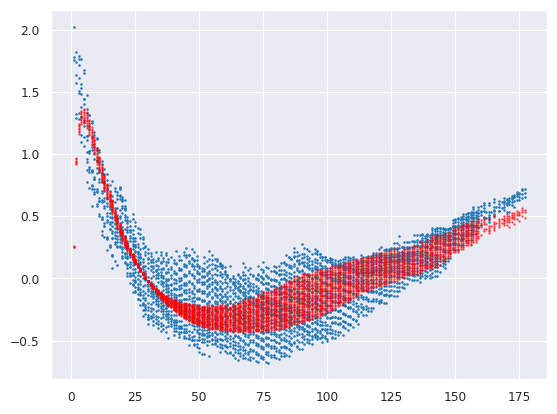

In [70]:
print("Default selection RMSE:", (np.power(model.predict(zn) - features[pc_number], 2).mean())**0.5)
plt.scatter(N, features[2,:], s=1)
plt.scatter(N, sr_features[:, 2], s=1, c='red', alpha=0.5)

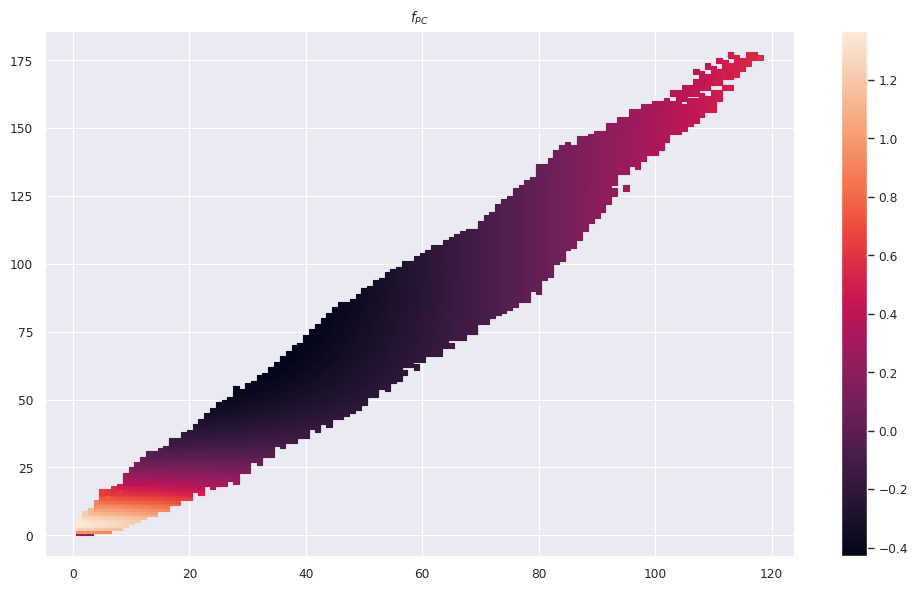

In [465]:
plt.figure(figsize=(10, 6))
sc = plt.scatter(Z, N, c=model.predict(zn), s=15, marker='s')
plt.title(r"$f_{{PC}}$") # Replace with your desired title
plt.colorbar(sc)
plt.tight_layout()
plt.show()

In [73]:
# Assuming data.X[:,:2].numpy() and zn are numpy arrays with two columns but possibly different row counts
inputs = X[:,:2].numpy()  # Extracting the relevant part of data.X
# zn is assumed to be already defined

# Convert arrays to structured arrays with the same dtype
dtype = [('col1', inputs.dtype), ('col2', inputs.dtype)]
X_struct = np.array(list(map(tuple, inputs)), dtype=dtype)
zn_struct = np.array(list(map(tuple, zn)), dtype=dtype)

# Use numpy's in1d to find matching rows
matches = np.in1d(X_struct, zn_struct)

# Apply the matches to y
y_matched = y[matches]
inputs_matched = inputs[matches]

In [74]:
pc_from_model = model.predict(inputs_matched[:,:2])

In [109]:
feats_inputs = features[:3].T

In [110]:
# prompt: linear regression for X_from_model to y=data_semf

from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
linreg.fit(feats_inputs, y_matched)

data_semf_res_from_reg = linreg.predict(feats_inputs)

In [113]:
data_semf_res_from_reg

array([-139357.11563383, -166191.17816488, -135252.60550141, ...,
       2120196.85006867, 2125886.49072777, 2126318.13787756])

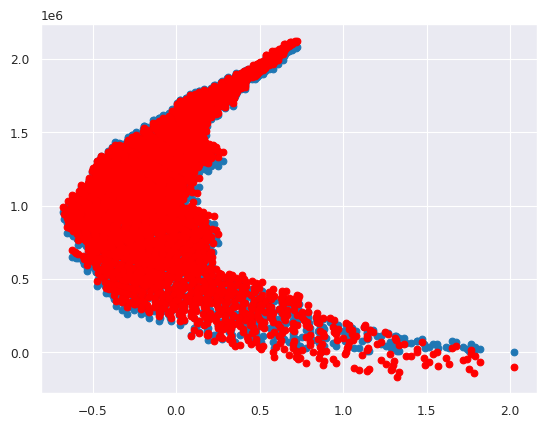

In [116]:
plt.scatter(features[2], y_matched)
plt.scatter(features[2], data_semf_res_from_reg, c='red')

In [117]:
preds_reg_pc_fitted_semf =  data_semf_res_from_reg

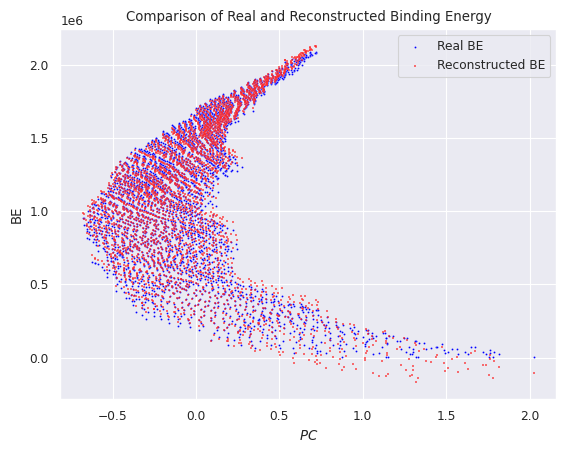

In [118]:
# Create a scatter plot for the real BE
sns.scatterplot(x=features[2], y=y_matched.flatten(),
                s=2, color='blue', label='Real BE')

# Create a scatter plot for the reconstructed BE
sns.scatterplot(x=features[2], y=preds_reg_pc_fitted_semf.flatten(),
                alpha=0.6, s=2, marker='s', color='red', label='Reconstructed BE')

# Labeling axes
plt.xlabel(rf'$PC$')  # Replace model.latex() with the actual function call
plt.ylabel('BE')

# Adding a legend and title
plt.legend()
plt.title('Comparison of Real and Reconstructed Binding Energy')

# Show the plot
plt.show()

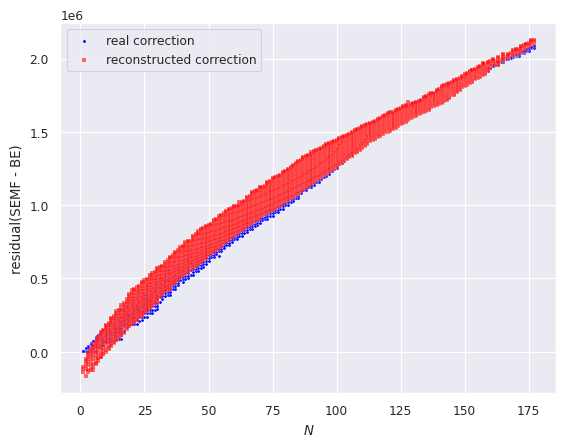

In [119]:
# Create a scatter plot for the real BE
sns.scatterplot(x=inputs_matched[:,1], y=y_matched.squeeze(),
                s=5, color='blue', label='real correction')


# Create a scatter plot for the reconstructed BE
sns.scatterplot(x=inputs_matched[:,1], y=data_semf_res_from_reg.squeeze(),
                alpha=0.6, s=5, marker='s', color='red', label='reconstructed correction')

# Labeling axes
plt.xlabel(rf'$N$')  # Replace model.latex() with the actual function call
plt.ylabel('residual(SEMF - BE)')

# Adding a legend and title
plt.legend()
# Show the plot
plt.show()

In [120]:
preds_reg_pc_fitted_semf

array([-139357.11563383, -166191.17816488, -135252.60550141, ...,
       2120196.85006867, 2125886.49072777, 2126318.13787756])

In [121]:
y_matched.numpy()

array([   2224.5662,    8481.796 ,    6881.7964, ..., 2078835.    ,
       2085048.    , 2081226.    ], dtype=float32)

In [122]:
rms_reg_semf = get_rms(preds_reg_pc_fitted_semf, y_matched.numpy(), inputs_matched)

In [123]:
rms_reg_semf

24615.217236597196

In [515]:
A = (inputs_matched[:,0] + inputs_matched[:,1])
print("SEMF rms:", np.mean(((semf_data*A - y_matched.numpy()))**2)**0.5)

SEMF rms: 7928.02400004463


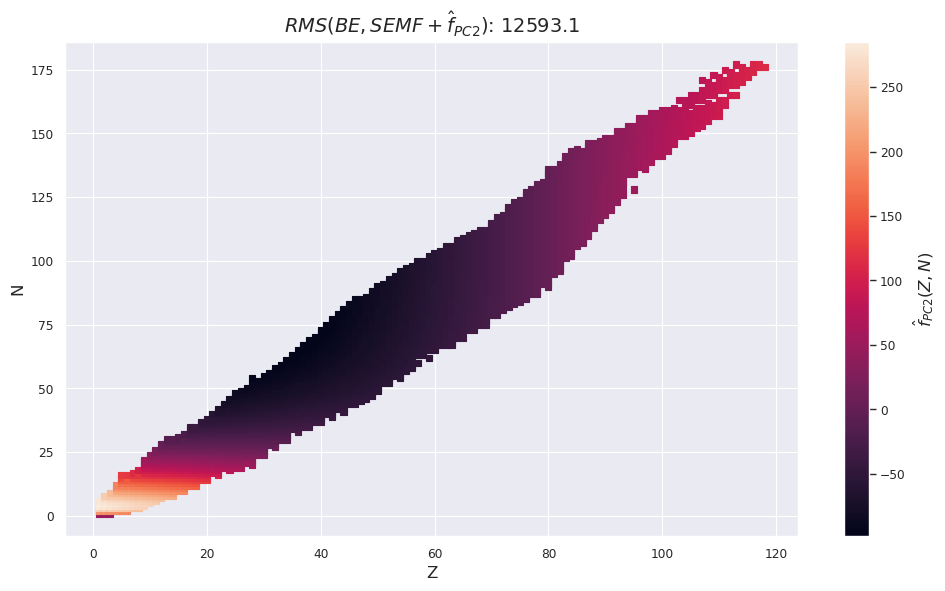

In [46]:
plt.figure(figsize=(10, 6))

# Scatter plot
sc = plt.scatter(X_matched[:,0], X_matched[:,1], c=data_semf_res_from_reg, s=20, marker='s')

# Enhancing the title
plt.title(fr"$RMS(BE, SEMF + \hat{{f}}_{{PC{pc_number}}})$: {round(rms_reg_semf, 2)}", fontsize=14)

# Adding axis labels with increased font size
plt.xlabel('Z', fontsize=12)
plt.ylabel('N', fontsize=12)

# Colorbar with label
cbar = plt.colorbar(sc)
cbar.set_label(fr"$\hat{{f}}_{{PC{pc_number}}}(Z,N)$", fontsize=12)

# Adjust layout and show plot
plt.tight_layout()
#plt.savefig(f"plots/f_pc{pc_number}.pdf")

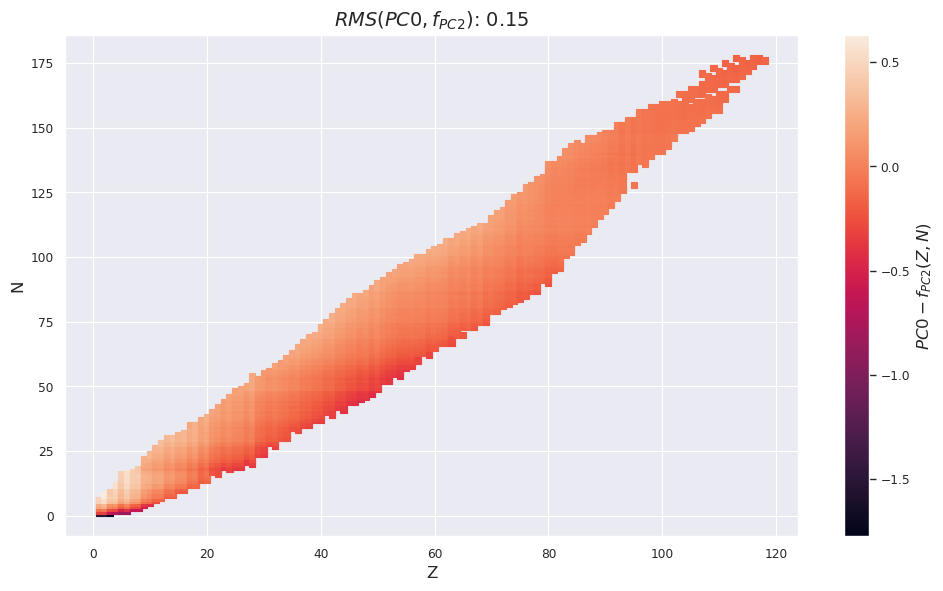

In [32]:
plt.figure(figsize=(10, 6))

reg_feat_res = pc_from_model - features[pc_number]
reg_feat_res_rms = np.power(reg_feat_res, 2).mean()**0.5
# Scatter plot
sc = plt.scatter(X_matched[:,0], X_matched[:,1], c=reg_feat_res, s=20, marker='s')

# Enhancing the title
plt.title(fr"$RMS(PC0, f_{{PC{pc_number}}})$: {round(reg_feat_res_rms, 2)}", fontsize=14)

# Adding axis labels with increased font size
plt.xlabel('Z', fontsize=12)
plt.ylabel('N', fontsize=12)

# Colorbar with label
cbar = plt.colorbar(sc)
cbar.set_label(fr"$PC0 - f_{{PC{pc_number}}}(Z,N)$", fontsize=12)

# Adjust layout and show plot
plt.tight_layout()
#plt.savefig(f"plots/f_pc{pc_number}_rms_feat.pdf")

In [122]:
def closed_form_linear_regression(X, y):
    X = np.array(X)
    y = np.array(y)

    X_b = np.c_[np.ones((len(X), 1)), X]

    theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

    # theta_best contains [b, a]
    b = theta_best[0]
    a = theta_best[1]

    return a, b

In [216]:
closed_form_linear_regression(pc_from_model.reshape(-1, 1), data_semf_res)

(0.7440489981832287, -7.93286907624266)

In [240]:
sympy_final_func = (model.sympy() * linreg.coef_) + linreg.intercept_

In [334]:
equations = model.equations_

In [241]:
from sympy import latex
# Extract the expression from the array
expr = sympy_final_func[0]

# Generate the LaTeX representation
latex_output = latex(expr)

# Print or return the LaTeX output
print(latex_output)

- 0.532087710506933 \cos{\left(\operatorname{isev}{\left(x_{0} \right)} \right)} - 0.532087710506933 \cos{\left(\operatorname{isev}{\left(x_{1} \right)} \right)} - 32.1581429979993


### Complexity vs. Error

In [400]:
rms_values = []
complexities = []

for i in range(0,13):
    # Prediction
    pc_from_model_preds = model.predict(zn, i)  # Assuming 'zn' is your input data

    # Linear Regression
    linreg = LinearRegression()
    linreg.fit(pc_from_model_preds.reshape(-1, 1), data_semf_res)
    data_semf_res_from_reg = linreg.predict(pc_from_model_preds.reshape(-1, 1))

    # Compute RMS
    #rms = get_rms(data_semf_res_from_reg + semf_data.numpy(), data_BE, X_matched[:,:2].numpy(), scale_by_A=True)
    rms = np.power(model.predict(zn, i) - features[pc_number], 2).mean()**0.5

    rms_values.append(rms)
    complexities.append(equations.complexity[i])

In [ ]:
equations

In [ ]:
rms_values

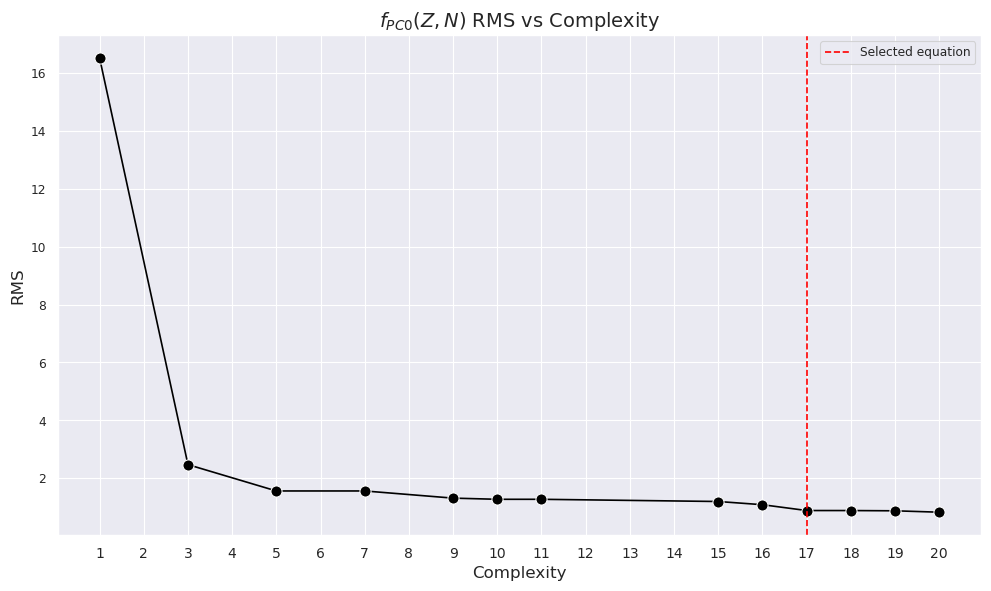

In [404]:
plt.figure(figsize=(10, 6))

# Smoothed line plot for RMS vs Complexity
sns.lineplot(x=complexities, y=rms_values, marker='o', color='black', markersize=8, linestyle='-')

# Customize the plot with labels and title
plt.xlabel('Complexity', fontsize=12)
plt.ylabel('RMS', fontsize=12)
plt.title(r'$f_{PC0}(Z,N)$ RMS vs Complexity', fontsize=14)

# Adding a red dashed vertical line at complexity = 17
plt.axvline(x=17, color='red', linestyle='--', label='Selected equation')

# Setting x-axis ticks to natural numbers within the range of complexities
min_complexity = min(complexities)
max_complexity = max(complexities)
plt.xticks(np.arange(min_complexity, max_complexity + 1, step=1), fontsize=10)
#plt.ylim(3980, 4000 + 20)
# Adding a legend
plt.legend()

# Adjust layout and show plot
plt.tight_layout()
plt.savefig('./plots/f_pc0_rms_complex.pdf')